In [5]:
import pandas as pd
from prophet import Prophet
import plotly.express as px

# Functions

In [9]:
from datetime import datetime


# function to remove last record if date is greater than sysdate

def datecheck(df):
    #Get todays date and convert to datetime format ymd
    today = datetime.today()
    
    #Get last date of dataframe
    last_dt = pd.to_datetime(df['ds'].tail(1))

    #test if last date is greater or equal to current datetime
    test_dt = last_dt <= today

    #if statement to remove last record from df given the last date is greater than current date
    if test_dt.bool() == True:
        return(df)
    else:
        df.drop(df.tail(1).index, inplace=True)
        return(df)


In [ ]:
import datecheck as datecheck

# URL request and data download csv

In [10]:
import pandas as pd
import time
from datetime import timedelta

#get the time now in unix time
now = int(time.time())

#get the time one year from now datetime object
last_year = datetime.today() - timedelta(days = 1825 )

#convert datetime object to unix timestamp
OneYr_ago = int(last_year.timestamp())

#Build Yahoo Finance Url request for SOL one year worth of data from Now 
#url = F'https://query1.finance.yahoo.com/v7/finance/download/SOL1-USD?period1={OneYr_ago}&period2={now}&interval=1d&events=history&includeAdjustedClose=true' #SOL
url = F'https://query1.finance.yahoo.com/v7/finance/download/ETH-USD?period1={OneYr_ago}&period2={now}&interval=1d&events=history&includeAdjustedClose=true' #ETH
#url = F'https://query1.finance.yahoo.com/v7/finance/download/XRP-USD?period1={OneYr_ago}&period2={now}&interval=1d&events=history&includeAdjustedClose=true'  #XRP
#url = F'https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1={OneYr_ago}&period2={now}&interval=1d&events=history&includeAdjustedClose=true' #BTC
#Get CSV file from Yahoo Finance
file = pd.read_csv(url)

#Convert download file to time series of date and close
file_ts = file[['Date','Close']]

#rename columns 'ds' = datestamp and Y = Y value for prophet
file_ts = file_ts.rename(columns={"Date": "ds", "Close": "y"})

#Drop Na values from file
df = file_ts.dropna(axis=0)

#use date check function to remove last row if date is greater than todays date
datecheck(df)

/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,ds,y
0,2016-10-15,11.983400
1,2016-10-16,11.951600
2,2016-10-17,12.005000
3,2016-10-18,12.588500
4,2016-10-19,12.022600
...,...,...
1819,2021-10-08,3563.759277
1820,2021-10-09,3575.716797
1821,2021-10-10,3425.852783
1822,2021-10-11,3545.354004


# Use FB prophet to perform time series prediction

In [72]:
#Initiate prophet object
m = Prophet(changepoint_prior_scale=0.6)

#Fit the prophet object to the downloaded data
m.fit(file_ts)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -106.863
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4577.42     0.0118735       548.167           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4633.1    0.00415529       497.538           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4662.33     0.0104183       524.522           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4683.73     0.0113065       105.489           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4710.32       0.26679        903.18           1           1      561   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [73]:
future = m.make_future_dataframe(periods=90)
future.tail()

,ds
1911,2022-01-06
1912,2022-01-07
1913,2022-01-08
1914,2022-01-09
1915,2022-01-10


In [74]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1911,2022-01-06,4273.546812,3683.621790,4801.303932
1912,2022-01-07,4289.531211,3640.508581,4843.960338
1913,2022-01-08,4308.570434,3704.877098,4847.017319
1914,2022-01-09,4325.229595,3703.567136,4863.679714
1915,2022-01-10,4339.132385,3662.830253,4845.492596


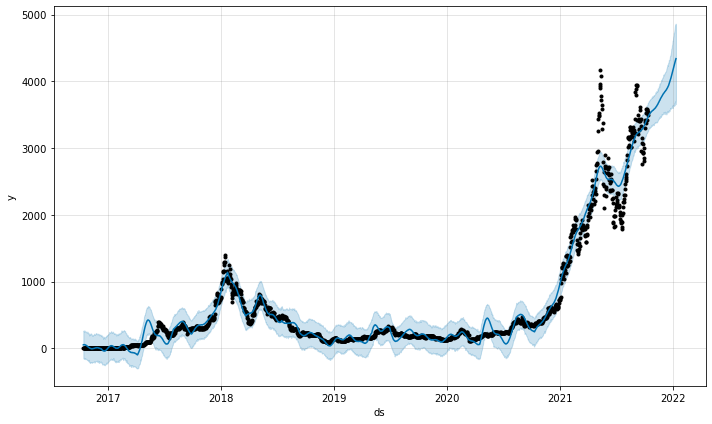

In [75]:
fig1 = m.plot(forecast)

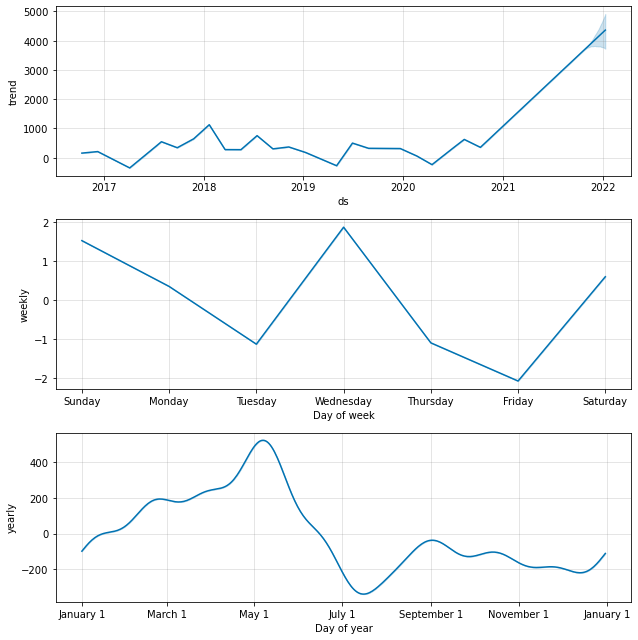

In [76]:
fig2 = m.plot_components(forecast)

In [77]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast,changepoints = True,trend = True)

# Cross Validation and Tunning

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools
import numpy as np

param_grid = {  
    'changepoint_prior_scale': [.7,0.75,0.8,.85,.90,.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Store the RMSEs for each params here
rmses = []  

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m,period='5 days', horizon='10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

In [44]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.95}


/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/prophet/plot.py:539: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/prophet/plot.py:540: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



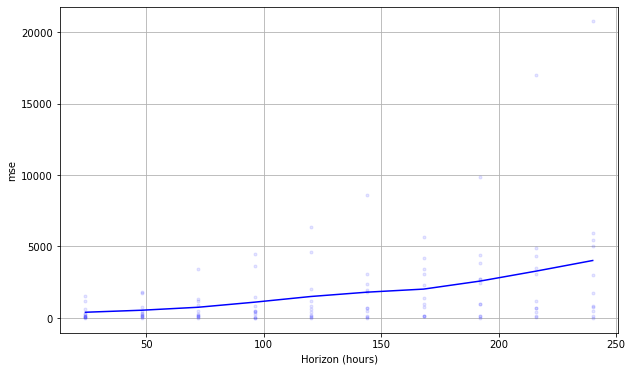

In [45]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mse',rolling_window = .1)

In [ ]:
dir()